# Road Damage Detection

<b>Objective:</b> To detect the damage in the road and classify it in a reasonable amount of time for the given input image.

<b>Business Benefit:</b> Better than manual and quantitative detection, it doesn't need a volunteer to detection and it's not computationally and cost wise expensive.

<b>Performance metric</b>: F1-Score 

## Dataset

Road Damage Dataset contains Images and their Annotation as the same format to PASCAL VOC. The dataset consist of images of roads of 3 different countries and the structure (file format) of dataset is as follow:
* Dataset 
    * Czech
        * Annotations : contains xml files of annotation
        * images : contains jpeg images of road
    * India
    * Japan
 
This dataset consistst of many damage categories but we are considering only 4 categories namely D00 (vertical cracks), D10 (horizontal cracks), D20(Alligator crack), and D40(potholes) to generalize the damage in many countries. 

Sample of an xml file of annotations

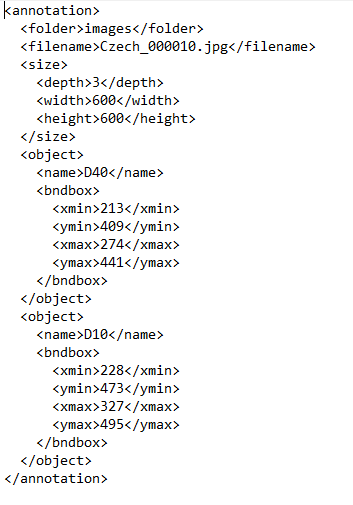

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import os
import cv2
import random
import math
from xml.etree import ElementTree
%matplotlib inline

In [9]:
base_path = 'Dataset/'

classes = ["D00", "D10", "D20", "D40"]

countries = ["Czech", "India", "Japan"]

In [83]:
anot_files = []            #storing all annotation file directories    
image_files = []           #storing all image files directories 
for country in countries:
    anot_files.extend([base_path + country + '/annotations/xmls/'+ filename for filename in os.listdir(base_path + country + '/annotations/xmls')])
    image_files.extend([base_path + country + '/images/'+ filename for filename in os.listdir(base_path + country + '/images')])

print(f'Total images in dataset: {len(image_files)}')

Total images in dataset: 21041


In [110]:
# the number of total images and total labels.
cls_names = []
l_images = 0

for i in anot_files:
    
    infile_xml = open(i)
    tree = ElementTree.parse(infile_xml)
    root = tree.getroot()
    if root.find('object'):
        for obj in root.iter('object'):
            cls_name = obj.find('name').text
            if cls_name in ['D00', 'D10', 'D20', 'D40']:
                cls_names.append(cls_name)
        
        l_images += 1

print(f"number of images with atleast 1 label：{l_images}")
print(f"number of labels：{len(cls_names)}")

number of images with atleast 1 label：14568
number of labels：25044


Count for each classes
D00 : 6592
D10 : 4446
D20 : 8381
D40 : 5627


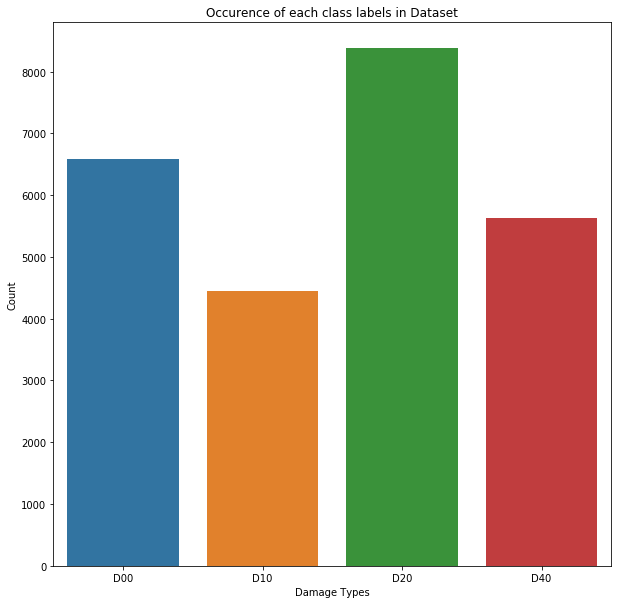

In [19]:
#number of each class labels
count_dict = collections.Counter(cls_names)
cls_count = []

print('Count for each classes')
for c in classes:
    cls_count.append(count_dict[c])
    print(f'{c} : {count_dict[c]}')
    
fig = plt.figure(figsize = (10, 10)) 
sns.barplot(x = classes, y = cls_count)  
plt.xlabel("Damage Types") 
plt.ylabel("Count") 
plt.title("Occurence of each class labels in Dataset") 
plt.show() 

In [35]:
# data analysis

count = []
cont = []
category = []   #counting total # images, D00, D10, D20, D40, # of labels

for country in countries:
    cont.extend([country]*6)
    category.extend(['# of images', 'D00', 'D10', 'D20', 'D40', '# of labels'])
    
    files = [filename for filename in os.listdir(base_path + country + '/annotations/xmls')]
    count.append(len(files))
    label_counts = [0,0,0,0]
    for i in files:
        infile_xml = open(base_path + country + '/annotations/xmls/' +i)
        tree = ElementTree.parse(infile_xml)
        root = tree.getroot()
        if root.find('object'):
            for obj in root.iter('object'):
                cls_name = obj.find('name').text
                if cls_name == 'D00':
                    label_counts[0] += 1
                elif cls_name == 'D10':
                    label_counts[1] += 1
                elif cls_name == 'D20':
                    label_counts[2] += 1
                elif cls_name == 'D40':
                    label_counts[3] += 1
            
    count.extend(label_counts)
    count.append(sum(label_counts))

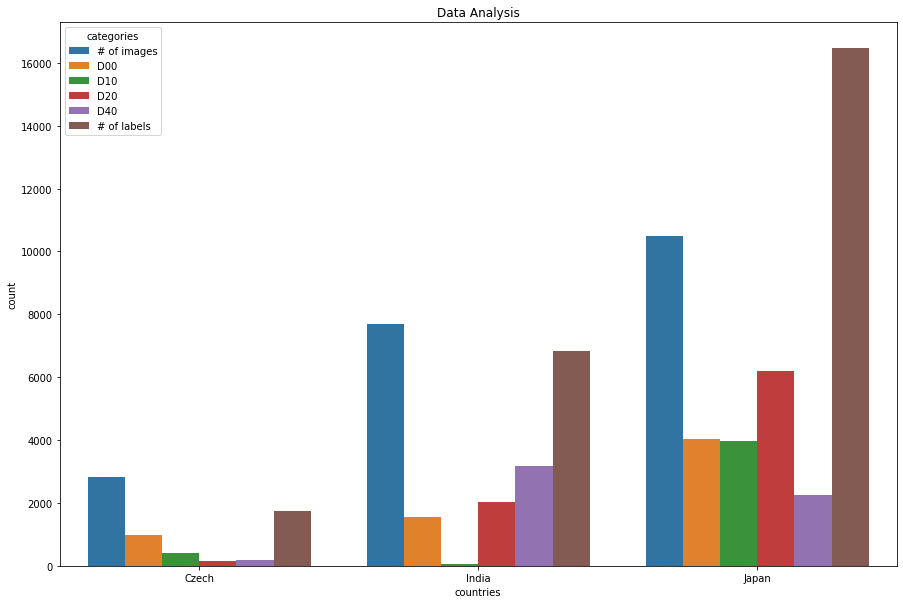

Data analysis of  Czech
    categories  count
0  # of images   2829
1          D00    988
2          D10    399
3          D20    161
4          D40    197
5  # of labels   1745
****************************************************************************************************
Data analysis of  India
     categories  count
6   # of images   7706
7           D00   1555
8           D10     68
9           D20   2021
10          D40   3187
11  # of labels   6831
****************************************************************************************************
Data analysis of  Japan
     categories  count
12  # of images  10506
13          D00   4049
14          D10   3979
15          D20   6199
16          D40   2243
17  # of labels  16470
****************************************************************************************************


In [50]:
data_analysis = pd.DataFrame({'countries':cont, 'count': count, 'categories':category})

fig = plt.figure(figsize = (15,10))

sns.barplot(x = 'countries', y = 'count', hue = 'categories', data = data_analysis)
plt.title('Data Analysis')
plt.show()

for i in countries:
    print('Data analysis of ',i)
    print(data_analysis[['categories', 'count']][data_analysis['countries'] == i])
    print('*'*100)

### Observations:
* Dataset consist of more than half road damage images of Japan, followed by around 30% of indian images and rest of Czech images.
* Both Czech and Indian dataset consist of images of road without damages also, but in Japan dataset there was rarely image with no damage. Therefore only japanese data has more number of labels than number of images.
* In Japanese roads Alligator cracks (D20) were found the most and less potholes (D40) compared to others.
* In Indian roads potholes (D40) were found the most and least lateral cracks(D10) compared to others.
* In Czech roads less alligator cracks (D20) and potholes (D40) compared to other two.


In [53]:
def draw_images(image_file, country):

    img = cv2.imread(base_path + country + '/images/' + image_file + '.jpg')
    
    infile_xml = open(base_path + country + '/annotations/xmls/' +image_file + '.xml')
    tree = ElementTree.parse(infile_xml)
    root = tree.getroot()
    
    for obj in root.iter('object'):
        cls_name = obj.find('name').text
        xmlbox = obj.find('bndbox')
        xmin = int(xmlbox.find('xmin').text)
        xmax = int(xmlbox.find('xmax').text)
        ymin = int(xmlbox.find('ymin').text)
        ymax = int(xmlbox.find('ymax').text)

        font = cv2.FONT_HERSHEY_SIMPLEX

        # put text
        cv2.putText(img,cls_name,(xmin,ymin-10),font,1,(0,255,0),2,cv2.LINE_AA)

        # draw bounding box
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0),3)
    return img

Images of Road Damages of  Czech


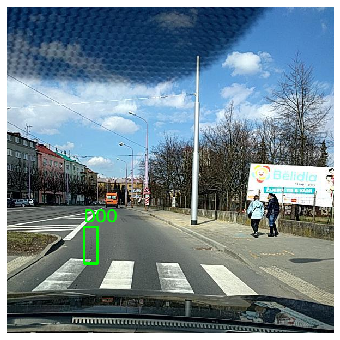

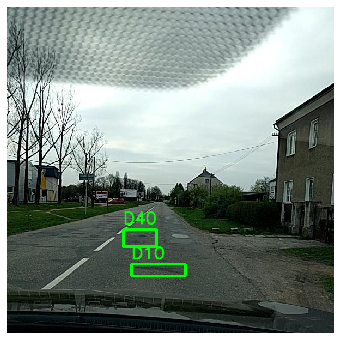

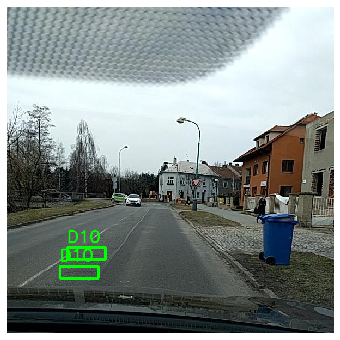

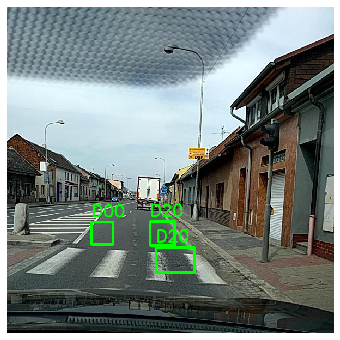

****************************************************************************************************
Images of Road Damages of  India


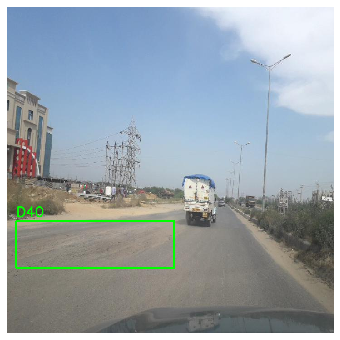

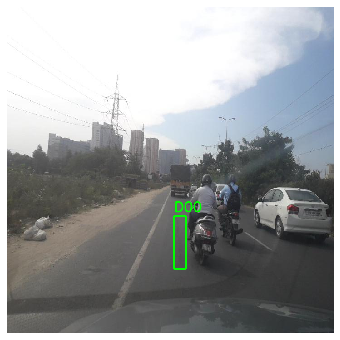

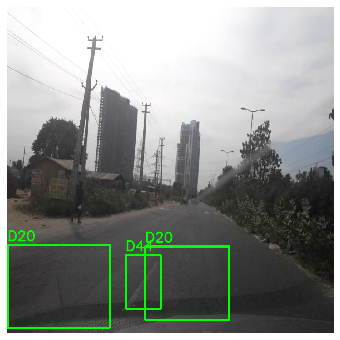

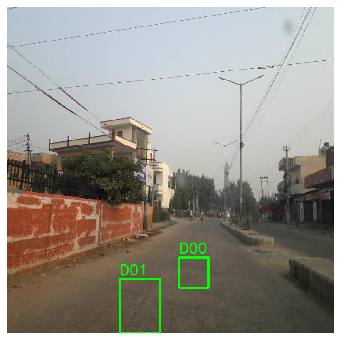

****************************************************************************************************
Images of Road Damages of  Japan


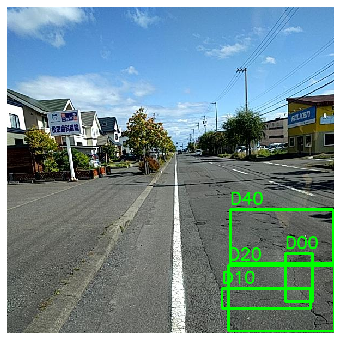

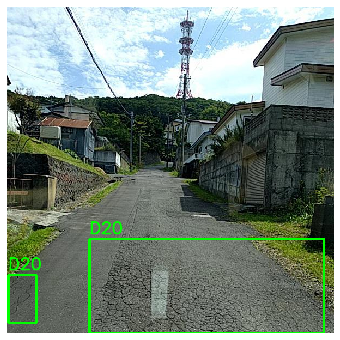

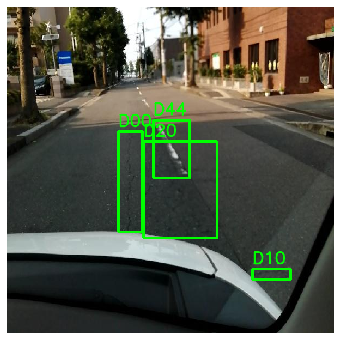

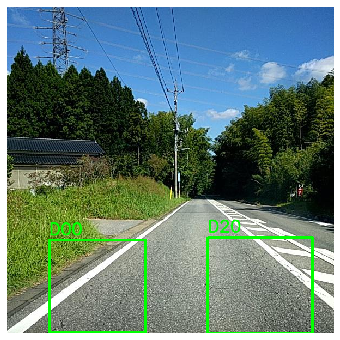

****************************************************************************************************


In [67]:
files = [['Czech_000006','Czech_000010','Czech_000020','Czech_000031'],['India_000005','India_000011','India_000014','India_000038'],
         ['Japan_000000', 'Japan_000003', 'Japan_000006', 'Japan_000011']]

for i in range(3):
    print('Images of Road Damages of ',countries[i])            
    for j in range(len(files[i])):
        fig = plt.figure(figsize = (6,6))
        img = draw_images(files[i][j], countries[i])
        plt.axis('off')
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
    print('*'*100)

Count of different sizes in overall dataset: [1379, 11821, 4931, 2671, 1789, 1228, 659, 137, 64, 8, 1, 0, 0]
Minimum size of a label: 0x1
Maximum size of a label: 704x492


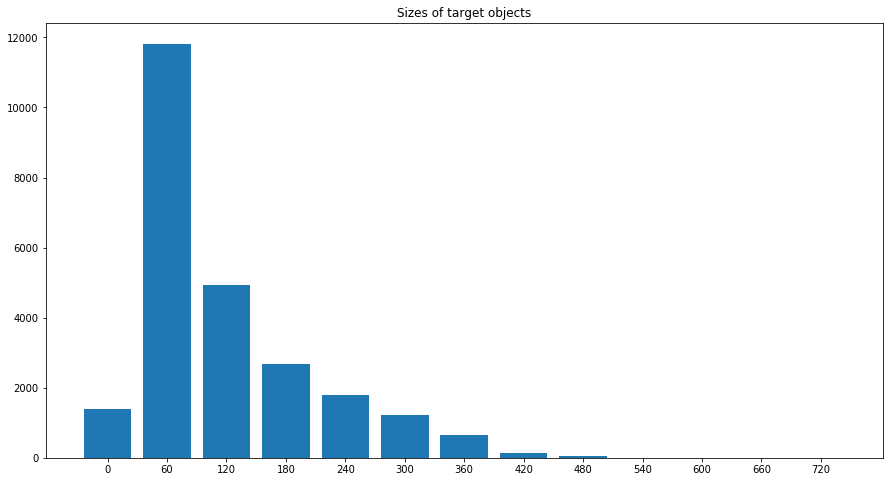

In [111]:
#getting sizes of all objects(target boxes)

sizes = []  #storing the size of each label
x = []
y =  []
object_size_num = [0 for i in range(13)]   #counting no of occureneces of that particular range in which the size belongs

for i in anot_files:
    
    infile_xml = open(i)
    tree = ElementTree.parse(infile_xml)
    root = tree.getroot()
    width = int(root.find('size')[0].text)
    if (root.find('object') != None) & (width < 1024): 
        for obj in root.iter('object'):
            cls_name = obj.find('name').text
            if cls_name in ['D00', 'D10', 'D20', 'D40']:
                xmin = int(obj.find('bndbox')[0].text)
                ymin = int(obj.find('bndbox')[1].text)
                xmax = int(obj.find('bndbox')[2].text)
                ymax = int(obj.find('bndbox')[3].text)
                l = xmax - xmin
                b = ymax - ymin
                obj_size = math.sqrt(l * b)
                sizes.append(obj_size)
                x.append(l)
                y.append(b)
                object_size_num[round(obj_size / 60)] += 1
    
print(f'Count of different sizes in overall dataset: {object_size_num}')

mi = sizes.index(min(sizes))
ma = sizes.index(max(sizes))

print(f'Minimum size of a label: {x[mi]}x{y[mi]}')
print(f'Maximum size of a label: {x[ma]}x{y[ma]}')

fig = plt.figure(figsize = (15,8))
plt.bar(list(map(str, range(0, 721, 60))), object_size_num)  
plt.title("Sizes of target objects")
plt.show()

## Conclusion:

* Dataset consist images of roads from 3 different countries (Czech, India, Japan).
* It is in Pascal VOC format in which for every image there is an xml file contains information about image and labels in it.
* Image were captured with smartphone plugged on a car dashboard. Images were captured at every 1 second i.e.i frame/sec and with spped of car around 40 km/hr.
* There are 21041 images of damages and around 25000 labels in it among them more than half of dataset consist from japan 
* There damages are categorised into 4 different classes according to their damage type.
* Samples images of each classes are displayed above.
* Analyzed sizes of all labels of each classes.